## Extração de características de batimentos cardiacos

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import entropy


In [2]:
import os
from os.path import join, dirname
from dotenv import load_dotenv

dotenv_path = join(dirname('__file__'), '.env')

load_dotenv(dotenv_path)

RAW_DATA = os.environ.get("RAW_DATA")
PROCESSED_DATA = os.environ.get("PROCESSED_DATA")
ROOT_PATH = os.environ.get("ROOT_PATH")


In [3]:
sem_crise = pd.read_parquet(
    '/mnt/c/Users/davi.nascimento/Documents/siena_eeg_ecg/data/processed/batimentos/sem_crise/PN00-2.parquet')
com_crise = pd.read_parquet(
    '/mnt/c/Users/davi.nascimento/Documents/siena_eeg_ecg/data/processed/batimentos/com_crise/PN00-2.parquet')


In [219]:
from math import e


def pandas_entropy(column, base=10):
    vc = pd.Series(column).value_counts(normalize=True, sort=False)
    base = e if base is None else base
    return -(vc * np.log(vc)/np.log(base)).sum()


def entropy1(labels, base=10):
    value, counts = np.unique(labels, return_counts=True)
    return entropy(counts, base=base)


In [220]:
x1 = sem_crise.iloc[:, :-1].T.agg(func=['var', 'skew', 'kurtosis'], axis=1)
x1.reset_index(drop=True)
x1['label'] = np.ones(len(x1))

ent1 = [entropy1(sem_crise[col].round()) for col in sem_crise.columns[:-1]]

x1['entropy'] = ent1

x1['var+entropy'] = x1['var'] + x1['entropy']
x1['skew+entropy'] = x1['skew'] + x1['entropy']
x1['kurtosis+entropy'] = x1['kurtosis'] + x1['entropy']


x2 = com_crise.iloc[:, :-1].T.agg(func=['var', 'skew', 'kurtosis'], axis=1)
x2.reset_index(drop=True)
x2['label'] = np.zeros(len(x2))


ent2 = [entropy1(com_crise[col].round()) for col in com_crise.columns[:-1]]

x2['entropy'] = ent2

x2['var+entropy'] = x2['var'] + x2['entropy']
x2['skew+entropy'] = x2['skew'] + x2['entropy']
x2['kurtosis+entropy'] = x2['kurtosis'] + x2['entropy']


In [221]:
X = pd.concat([x1, x2]).reset_index(drop=True)

X.columns

Index(['var', 'skew', 'kurtosis', 'label', 'entropy', 'var+entropy',
       'skew+entropy', 'kurtosis+entropy'],
      dtype='object')

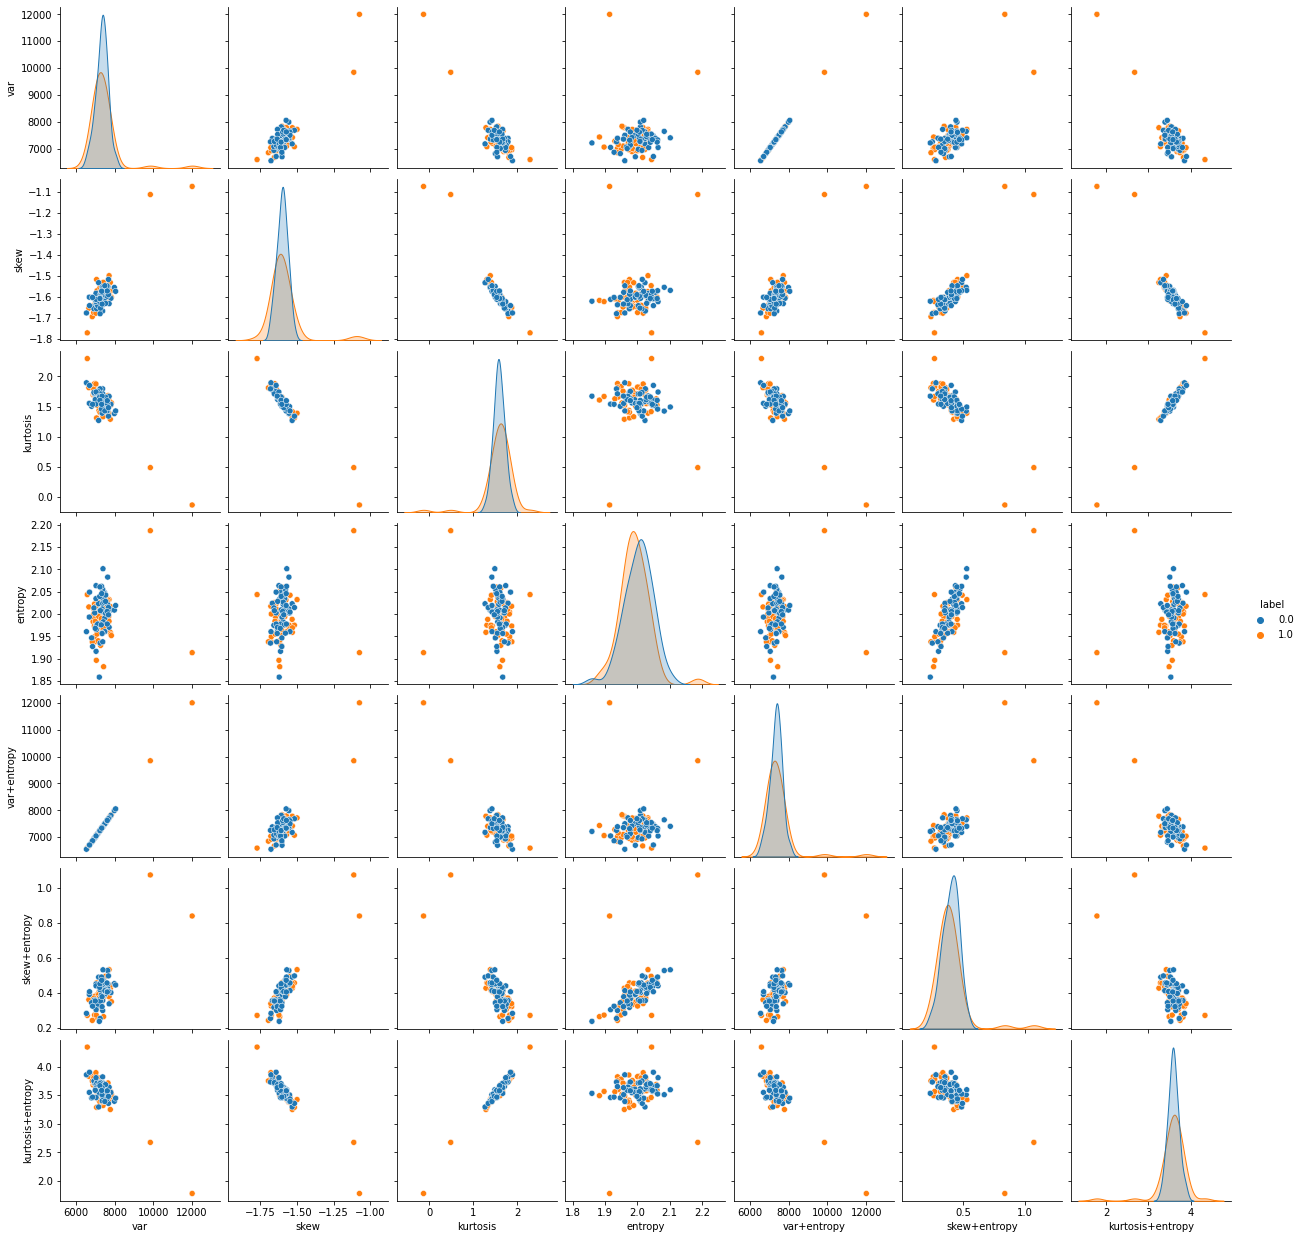

In [222]:
import seaborn as sns

sns.pairplot(X, hue='label')


In [223]:
from sklearn.svm import SVC
# for splitting the data into train and test samples
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA


x = X.loc[:, ['var', 'skew', 'kurtosis', 'entropy', 'var+entropy','skew+entropy', 'kurtosis+entropy']]
y = X.loc[:, 'label']


# pca = PCA(n_components=2)
# pca.fit(x)

# x_ = pca.transform(x)

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0)

model = SVC(kernel='rbf', probability=True, C=1, gamma=0.000001)
clf = model.fit(X_train, y_train)

pred_labels_tr = model.predict(X_train)
pred_labels_te = model.predict(X_test)

print('----- Evaluation on Test Data -----')
score_te = model.score(X_test, y_test)
print('Accuracy Score: ', score_te)
# Look at classification report to evaluate the model
print(classification_report(y_test, pred_labels_te))
print('--------------------------------------------------------')
print('----- Evaluation on Training Data -----')
score_tr = model.score(X_train, y_train)
print('Accuracy Score: ', score_tr)
# Look at classification report to evaluate the model
print(classification_report(y_train, pred_labels_tr))
print('-------------------------------------------------------')

----- Evaluation on Test Data -----
Accuracy Score:  0.5
              precision    recall  f1-score   support

         0.0       0.50      0.82      0.62        11
         1.0       0.50      0.18      0.27        11

    accuracy                           0.50        22
   macro avg       0.50      0.50      0.44        22
weighted avg       0.50      0.50      0.44        22

--------------------------------------------------------
----- Evaluation on Training Data -----
Accuracy Score:  0.5
              precision    recall  f1-score   support

         0.0       0.50      0.95      0.66        44
         1.0       0.50      0.05      0.08        44

    accuracy                           0.50        88
   macro avg       0.50      0.50      0.37        88
weighted avg       0.50      0.50      0.37        88

-------------------------------------------------------


<AxesSubplot:xlabel='label', ylabel='var'>

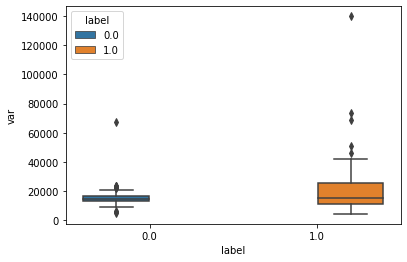

In [78]:
sns.boxplot(data=X, x='label', y='var', hue='label')


In [88]:
def entropy1(labels):
    base = None
    value, counts = np.unique(labels, return_counts=True)
    result = entropy(counts, base=base)
    return result


In [192]:
def func(x):
    v, c = np.unique(x.to_numpy().round(), return_counts=True)
    return entropy(c, base=10.0)


a = np.array([func(sem_crise[col]) for col in sem_crise.columns[:-1]])
b = np.array([func(com_crise[col]) for col in com_crise.columns[:-1]])


In [195]:
x1['var'].to_numpy()


array([3040.3405611 , 3239.46269069, 3455.79505265, 3719.93072117,
       2617.0694143 , 4438.6924667 , 3295.68445521, 3438.27690195,
       3530.5548806 , 3329.84466585, 3810.19762413, 3073.2310465 ,
       2816.62992926, 3869.08919554, 3559.97615104, 3789.25409462,
       3420.93742239, 3408.48175568, 4452.3662755 , 3040.25944126,
       3351.90704177, 3425.38909875, 3319.77967728, 3397.28396661,
       3173.8422649 , 3872.97940789, 3608.48179695, 2981.00212923,
       3323.9164781 , 2794.9312599 , 3519.70608926, 3242.38176803,
       3489.44409755, 3772.64466277, 3200.91448362, 3206.01957187,
       3580.75981956, 3364.84188502, 4718.58371883, 2910.38460607,
       3696.54325135, 3187.66221408, 3388.66457736, 2942.38406589,
       3162.91234151, 3211.27449456, 3335.64921187, 3146.19869925,
       3354.93042555, 3072.96589516, 3428.78872928, 3118.36952321,
       3608.79164907, 3515.75203413, 3311.31530604, 3037.88633268,
       3117.64827388, 3210.98020882, 3021.45716379, 3464.74503

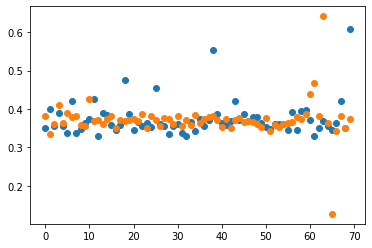

In [200]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(a)), a**x1['skew'].to_numpy(), 'o')
plt.plot(np.arange(len(b)), b**x2['skew'].to_numpy(), 'o')


In [89]:
sem_crise.iloc[:, :-1].T.agg(func=['var', 'skew',
                             'kurtosis', entropy1], axis=1)


ValueError: cannot combine transform and aggregation operations

In [86]:
com_crise.ilo


,Signal_1,Signal_2,Signal_3,Signal_4,Signal_5,Signal_6,Signal_7,Signal_8,Signal_9,Signal_10,...,Signal_74,Signal_75,Signal_76,Signal_77,Signal_78,Signal_79,Signal_80,Signal_81,Signal_82,label
0,58.289892,106.569831,91.190174,59.108371,93.245295,14.653153,44.256795,66.059858,27.742316,72.440034,...,49.073695,63.408149,47.965474,61.418663,66.280322,61.528745,64.373628,67.047719,64.980904,com_crise
1,58.767207,122.325291,81.350806,50.543118,101.002482,14.409316,43.577401,68.854340,31.483057,74.840699,...,49.582829,63.164884,48.060921,61.556688,65.304653,60.887938,63.856769,67.251110,64.763922,com_crise
2,58.180022,137.163873,68.001884,42.740666,108.301613,15.384903,43.356214,73.173081,34.766088,77.088990,...,49.787217,63.074235,48.460712,61.542614,64.328832,60.399599,63.340133,67.149108,64.547217,com_crise
3,56.223331,144.985569,53.125910,35.548516,113.922687,16.817415,43.593231,78.101079,37.591409,78.422406,...,49.839361,63.288699,48.859845,61.376441,63.657857,60.063729,62.823717,66.741711,64.330783,com_crise
4,53.354622,143.807876,39.772888,29.424169,117.560700,19.011855,44.745951,81.045833,40.111524,78.230947,...,49.891762,63.808274,49.258320,61.210670,63.291727,59.880330,62.612520,66.333920,64.114620,com_crise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,21.840016,36.552906,24.085655,46.559680,-47.329519,33.899604,31.615232,13.182461,50.774498,41.302689,...,22.026550,53.531485,34.627757,21.767631,30.710917,19.985088,12.242756,35.378126,12.380643,com_crise
367,34.260183,34.393240,24.348066,42.774543,-44.548107,35.220627,31.720450,8.407116,49.502220,41.144980,...,21.595867,52.259018,33.652693,21.865769,30.395885,20.032179,9.991563,35.089417,11.672624,com_crise
368,46.526793,33.146427,22.780289,38.531652,-41.462119,37.457397,31.825081,3.631378,48.077601,40.987402,...,21.013009,51.138397,32.830167,22.116479,30.385613,20.232131,8.197481,35.106071,11.116135,com_crise
369,56.809835,32.964971,21.974828,33.983506,-38.071550,39.542416,31.471623,-0.077252,46.958139,40.219955,...,20.430476,50.169622,32.160180,22.519758,30.680103,20.432444,6.708010,34.970592,10.558678,com_crise
